In [1]:
p53_genes = [
    'TP53', 'CDKN1A', 'MDM2', 'BAX', 'GADD45A', 'FAS', 'BBC3', 'NOXA', 'PMAIP1',
    'CCND1', 'CDK2', 'CDK4', 'RB1', 'E2F1', 'ATM', 'ATR', 'CHEK1', 'CHEK2',
    'CASP3', 'CASP8', 'CASP9', 'CYCS', 'BCL2', 'BCL2L1', 'BID',
    'GADD45B', 'GADD45G', 'PCNA', 'SESN1', 'SESN2', 'SFN', 'ZMAT3',
    'RRM2B', 'DDB2', 'XPC', 'PMAIP1', 'TP73', 'TP63', 'PTEN', 'AKT1', 'PIK3CA',
    'CDKN2A', 'CCNE1', 'CDK6', 'FOXO3', 'MAPK14', 'MAPK8', 'MAPK9', 'JUN', 'FOS'
]
p53_genes = ["SIAH1","IGFBP3","GADD45G","GADD45A","GADD45B","MDM4","CHEK1","ATR","CHEK2","ATM","RPRM","SFN","CDK2","CCNE1","CCNE2","TSC2","PPM1D",
              "TP73","CCNG1","CCNG2","RRM2","DDB2","STEAP3","PTEN","SERPINB5","CD82","THBS1","IGF1","SERPINE1","ADGRB1","CDKN2A","CDKN1A","ZMAT3",
              "BID","EI24","TP53I3","FAS","GTSE1","BAX","PIDD1","TNFRSF10B","CASP8","CDK1","APAF1","CYCS","CASP9","MDM2","TP53","RCHY1","CDK4","CDK6",
              "CCND1","CCND2","CCND3","PERP","SESN1","CCNB1","CCNB2","CASP3","TP53AIP1","BBC3","PMAIP1","SIVA1","BCL2L1","BCL2","PPP1R13L",]
len(p53_genes)

66

In [2]:
from pathlib import Path
import networkx as nx

def create_topo_file_from_graph(network_name, G: nx.DiGraph, dir):
    """
    Create a topo file as expected by racipe from a nx Graph
    and store it in the const.TOPO_PATH directory.
    :param G: nx Graph
    """
    new_file_path = Path(dir) / f"{network_name}.topo" 
    # save graph to a trrust.topo file with the header Source Target Type
    with open(new_file_path, "w") as f:
        f.write("Source Target Type\n")
        for u, v, d in G.edges(data='2'):
            print(f"Adding edge {u} -> {v} with weight {d}")
            f.write(f"{u} {v} {d}\n")

In [3]:
# load dorothea_human_full.csv
import networkx as nx
import pandas as pd
dorothea_df = pd.read_csv('dorothea_human_full.csv')


In [4]:
from pathlib import Path
def create_topo_file_from_graph(network_name, G: nx.DiGraph, dir):
    """
    Create a 
     file as expected by racipe from a nx Graph
    and store it in the const.TOPO_PATH directory.
    :param G: nx Graph
    """
    new_file_path = Path(dir) / f"{network_name}.topo" 
    # save graph to a trrust.topo file with the header Source Target Type
    with open(new_file_path, "w") as f:
        f.write("Source Target Type\n")
        for u, v, d in G.edges(data='mor'):
            # check if d is nan
            if pd.isna(d):
                print(f"Edge {u} -> {v} has no weight, set to 1")
                d = 1
            d = 1 if d > 0 else 2  # Convert to 1 for activation, 2 for inhibition
            f.write(f"{u} {v} {d}\n")

In [5]:
import matplotlib.pyplot as plt

def plot_dorothea_graph(G):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightgreen')
    # Determine edge colors based on 'mor' attribute
    edge_colors = []
    for u, v, d in G.edges(data=True):
        mor = d.get('mor', 1)
        edge_colors.append('red' if mor < 0 else 'green')
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color=edge_colors)
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')
    plt.title("Dorothea Subgraph with Key TFs")
    plt.axis('off')
    plt.show()

In [6]:

def create_dorothea_graph(dorothea_df):
    G = nx.DiGraph()
    for _, row in dorothea_df.iterrows():
        G.add_edge(row['source'], row['target'], confidence=row['confidence'], mor=row['mor'])
    return G

G = create_dorothea_graph(dorothea_df)

#group df by confidence and mor. print value counts for each group
confidence_counts = dorothea_df.groupby(['confidence', 'mor']).size().reset_index(name='count')
print("Value counts of confidence and mor in the Dorothea dataset:")
print(confidence_counts)

Value counts of confidence and mor in the Dorothea dataset:
  confidence       mor   count
0          A -1.000000     717
1          A  1.000000    5363
2          B -0.500000      22
3          B  0.500000    9011
4          C -0.333333      31
5          C  0.333333   17131
6          D -0.250000    1293
7          D  0.250000  243163


In [9]:
#filter out edges with confidence not in A, B, C
def filter_edges_by_confidence(G, valid_confidences):
    filtered_graph = G.copy()
    edges_to_remove = [(u, v) for u, v, d in filtered_graph.edges(data=True) if d['confidence'] not in valid_confidences]
    filtered_graph.remove_edges_from(edges_to_remove)
    filtered_graph.remove_nodes_from(list(nx.isolates(G)))
    return filtered_graph
# Filter the subgraph to keep only edges with confidence A, B, C
print(f"Unfiltered subgraph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
valid_confidences = ['A','B', 'C']
G_filtered = filter_edges_by_confidence(G, valid_confidences)
# drop isolated nodes
G_filtered = G_filtered.copy()
G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))
# Print info about the filtered graph
print(f"Filtered subgraph: {G_filtered.number_of_nodes()} nodes, {G_filtered.number_of_edges()} edges")
#print amount of weakly connected components in the filtered graph
num_components = nx.number_weakly_connected_components(G_filtered)
print(f"Number of weakly connected components in filtered subgraph: {num_components}")
print(f"size of all components in filtered subgraph: {[len(c) for c in nx.weakly_connected_components(G_filtered)]}")
# choose the largest component
largest_component = max(nx.weakly_connected_components(G_filtered), key=len)
G_filtered = G_filtered.subgraph(largest_component).copy()

Unfiltered subgraph: 18577 nodes, 276731 edges
Filtered subgraph: 9300 nodes, 32275 edges
Number of weakly connected components in filtered subgraph: 1
size of all components in filtered subgraph: [9300]


In [16]:
# interesting nodes TP53, MTOR, MAPK1, MAPK3, MAPK14, MAPK8, MAPK9, JUN, FOS
interesting_nodes = ['TP53', 'MTOR', 'MAPK1', 'MAPK3', 'MAPK14', 'MAPK8', 'MAPK9', 'JUN', 'FOS']
# check if interesting nodes are in the filtered graph
for node in interesting_nodes:
    if node in G_filtered:
        print(f"{node} is in the filtered graph")
    else:
        print(f"{node} is NOT in the filtered graph")

TP53 is in the filtered graph
MTOR is NOT in the filtered graph
MAPK1 is in the filtered graph
MAPK3 is in the filtered graph
MAPK14 is in the filtered graph
MAPK8 is in the filtered graph
MAPK9 is in the filtered graph
JUN is in the filtered graph
FOS is in the filtered graph


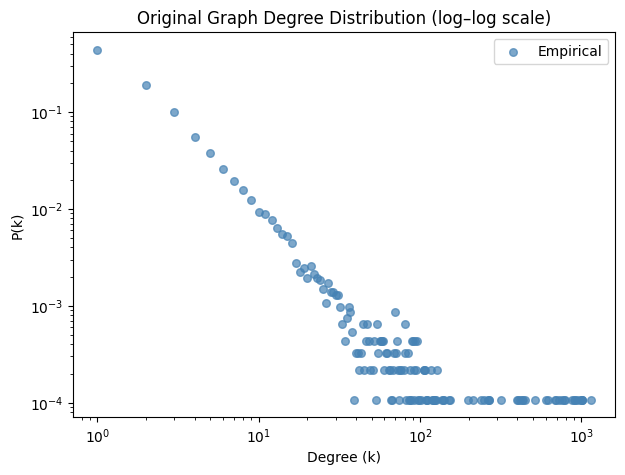

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

degree_sequence = [d for _, d in G_filtered.degree()]
degree_count = Counter(degree_sequence)

# Sort degrees
deg, cnt = zip(*sorted(degree_count.items()))

# Convert to probabilities
deg = np.array(deg)
cnt = np.array(cnt)
p_k = cnt / cnt.sum()

plt.figure(figsize=(7,5))
plt.scatter(deg, p_k, color='steelblue', s=30, alpha=0.7, label='Empirical')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.title("Original Graph Degree Distribution (log–log scale)")

# Filter out zero probabilities
mask = (p_k > 0) & (deg > 0)
log_deg = np.log10(deg[mask])
log_p = np.log10(p_k[mask])
plt.legend()
plt.show()



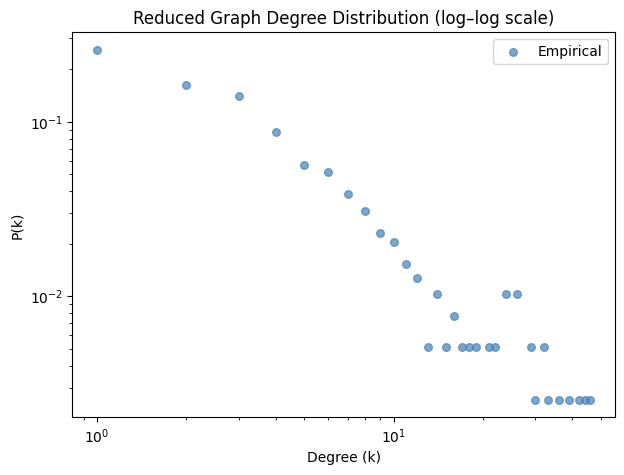

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

degree_sequence = [d for _, d in G_reduced_copy.degree()]
degree_count = Counter(degree_sequence)

# Sort degrees
deg, cnt = zip(*sorted(degree_count.items()))

# Convert to probabilities
deg = np.array(deg)
cnt = np.array(cnt)
p_k = cnt / cnt.sum()

plt.figure(figsize=(7,5))
plt.scatter(deg, p_k, color='steelblue', s=30, alpha=0.7, label='Empirical')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.title("Reduced Graph Degree Distribution (log–log scale)")

# Filter out zero probabilities
mask = (p_k > 0) & (deg > 0)
log_deg = np.log10(deg[mask])
log_p = np.log10(p_k[mask])
plt.legend()
plt.show()

In [11]:
import networkx as nx
import numpy as np

def reduce_graph_to_n_nodes(G, n, batch_size=10):
    """
    Reduce G to <= n nodes, keeping only the largest weakly connected component at each step.
    Drop nodes based on inverse out-degree probability, in batches.
    """
    # Always work on a copy
    G = G.copy()

    while True:
        # Step 1: Get largest WCC
        largest_component = max(nx.weakly_connected_components(G), key=len)
        G = G.subgraph(largest_component).copy()

        if G.number_of_nodes() <= n:
            break

        # Step 2: Compute drop probabilities
        nodes = np.array(G.nodes())
        out_degrees = np.array([G.out_degree(node) for node in nodes])
        epsilon = 1e-6
        inv_out_degrees = 1 / (np.sqrt(out_degrees) + epsilon)
        probabilities = inv_out_degrees / inv_out_degrees.sum()

        # Step 3: Drop a batch of nodes
        drop_count = min(batch_size, G.number_of_nodes() - n)
        drop_nodes = np.random.choice(nodes, size=drop_count, replace=False, p=probabilities)
        G.remove_nodes_from(drop_nodes)

    return G


# Reduce the filtered graph to 150 nodes
target_size = 500
G_reduced = reduce_graph_to_n_nodes(G_filtered, target_size)
# print number of weakly connected components in the reduced graph
num_components = nx.number_weakly_connected_components(G_reduced)
print(f"Number of weakly connected components in reduced graph: {num_components}")
print(f"Number of nodes in reduced graph: {G_reduced.number_of_nodes()}")

Number of weakly connected components in reduced graph: 1
Number of nodes in reduced graph: 500


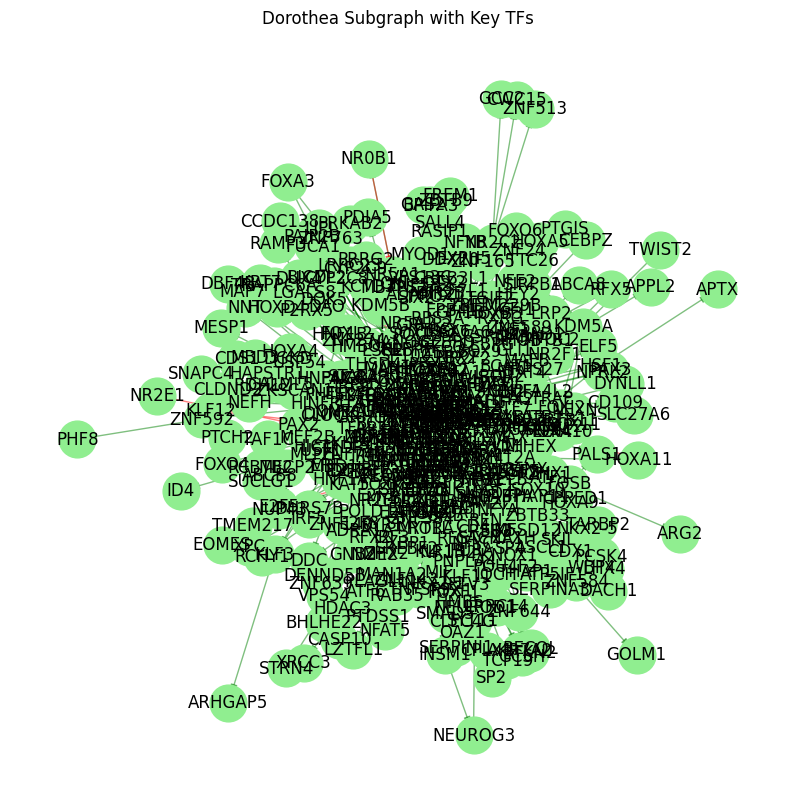

Number of nodes in reduced graph: 500
Number of edges in reduced graph: 2708


In [12]:
#visualize the reduced graph
plot_dorothea_graph(G_reduced)
# give some statistics about the reduced graph
print(f"Number of nodes in reduced graph: {G_reduced.number_of_nodes()}")
print(f"Number of edges in reduced graph: {G_reduced.number_of_edges()}")

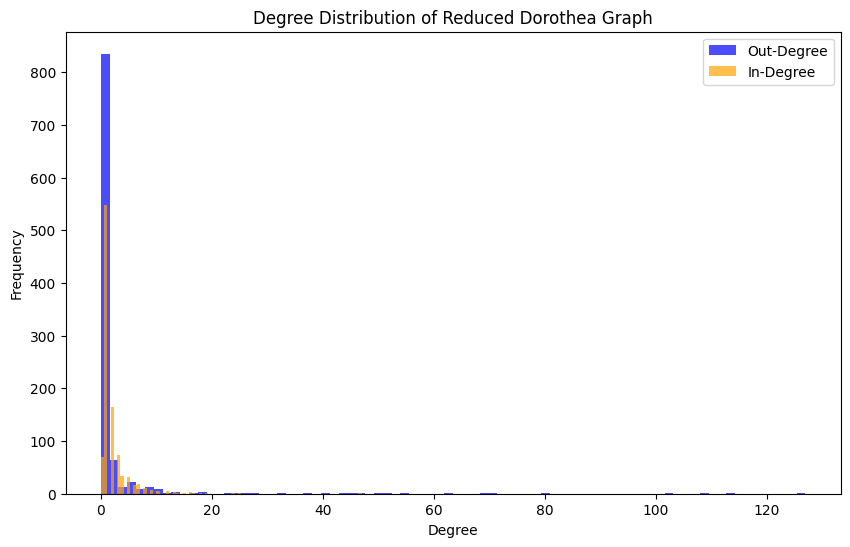

In [12]:
# create a histogram of the out-degree and in-degree distribution of the reduced graph
plt.figure(figsize=(10, 6))
out_degree_sequence = [d for n, d in G_reduced.out_degree()]
in_degree_sequence = [d for n, d in G_reduced.in_degree()]
plt.hist(out_degree_sequence, bins=80, color='blue', alpha=0.7, label='Out-Degree')
plt.hist(in_degree_sequence, bins=80, color='orange', alpha=0.7, label='In-Degree')
plt.title("Degree Distribution of Reduced Dorothea Graph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()
plt.show()

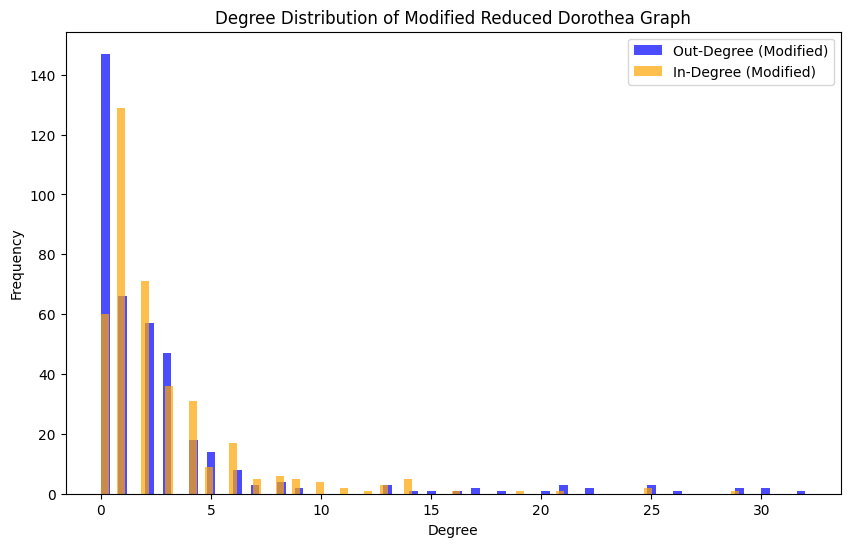

In [17]:
# copy the reduced graph, select 500 edges by random an detelete them. plot in and out degree distribution
import random
def randomly_remove_edges(G, num_edges_to_remove):
    """
    Randomly remove a specified number of edges from the graph.
    """
    if num_edges_to_remove >= G.number_of_edges():
        return G  # No edges to remove if the number is greater than or equal to existing edges
    
    edges = list(G.edges())
    edges_to_remove = random.sample(edges, num_edges_to_remove)
    
    G.remove_edges_from(edges_to_remove)
    
    return G

# Create a copy of the reduced graph
#G_reduced_copy = G_reduced.copy()
# Remove 500 edges randomly
num_edges_to_remove = 400
G_reduced_copy = randomly_remove_edges(G_reduced, num_edges_to_remove)

# select the largest weakly connected component from the modified graph
largest_component_copy = max(nx.weakly_connected_components(G_reduced_copy), key=len)
G_reduced_copy = G_reduced_copy.subgraph(largest_component_copy).copy()

# Plot the in-degree and out-degree distribution of the modified graph
plt.figure(figsize=(10, 6))
out_degree_sequence_copy = [d for n, d in G_reduced_copy.out_degree()]
in_degree_sequence_copy = [d for n, d in G_reduced_copy.in_degree()]
plt.hist(out_degree_sequence_copy, bins=80, color='blue', alpha=0.7, label='Out-Degree (Modified)')
plt.hist(in_degree_sequence_copy, bins=80, color='orange', alpha=0.7, label='In-Degree (Modified)')
plt.title("Degree Distribution of Modified Reduced Dorothea Graph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [18]:
print(f"Number of nodes in modified reduced graph: {G_reduced_copy.number_of_nodes()}")
print(f"Number of edges in modified reduced graph: {G_reduced_copy.number_of_edges()}")

Number of nodes in modified reduced graph: 390
Number of edges in modified reduced graph: 1096


In [92]:
G_reduced_copy = G_reduced.copy()

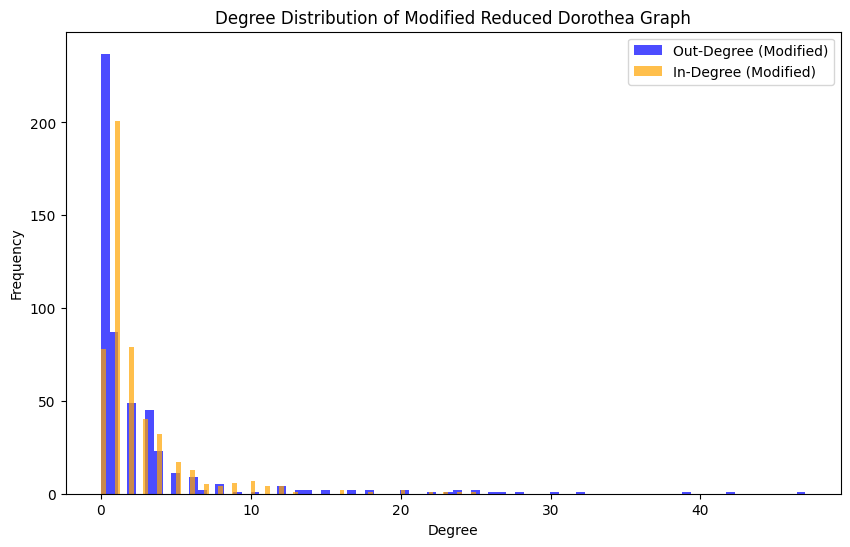

In [45]:
import random

def randomly_remove_edges_preserving_connectivity(G, num_edges_to_remove):
    """
    Randomly remove edges from the graph, but do not remove an edge if it would disconnect (weakly) a node.
    Preserve all edge attributes.
    """
    G = G.copy()
    edges = list(G.edges(data=True))
    removed = 0

    random.shuffle(edges)
    for u, v, attr in edges:
        if removed >= num_edges_to_remove:
            break
        # Store attributes before removing
        edge_attrs = attr.copy()
        G.remove_edge(u, v)
        # If either node is now isolated or graph is disconnected, restore the edge with all attributes
        if nx.number_weakly_connected_components(G) > 1 or (G.out_degree(u) + G.in_degree(u) == 0 or G.out_degree(v) + G.in_degree(v) == 0):
            G.add_edge(u, v, **edge_attrs)
        else:
            removed += 1
    return G

# Remove 100 edges randomly, preserving connectivity
num_edges_to_remove = 125
G_reduced_copy = randomly_remove_edges_preserving_connectivity(G_reduced_copy, num_edges_to_remove)

# select the largest weakly connected component from the modified graph
largest_component_copy = max(nx.weakly_connected_components(G_reduced_copy), key=len)
G_reduced_copy = G_reduced_copy.subgraph(largest_component_copy).copy()

# Plot the in-degree and out-degree distribution of the modified graph
plt.figure(figsize=(10, 6))
out_degree_sequence_copy = [d for n, d in G_reduced_copy.out_degree()]
in_degree_sequence_copy = [d for n, d in G_reduced_copy.in_degree()]
plt.hist(out_degree_sequence_copy, bins=80, color='blue', alpha=0.7, label='Out-Degree (Modified)')
plt.hist(in_degree_sequence_copy, bins=80, color='orange', alpha=0.7, label='In-Degree (Modified)')
plt.title("Degree Distribution of Modified Reduced Dorothea Graph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [46]:
# print n nodes n edges in the modified graph
print(f"Number of nodes in modified reduced graph: {G_reduced_copy.number_of_nodes()}")
print(f"Number of edges in modified reduced graph: {G_reduced_copy.number_of_edges()}")

Number of nodes in modified reduced graph: 500
Number of edges in modified reduced graph: 1250


In [19]:
# save g reduced copy as topo
create_topo_file_from_graph("dorothea_390_1096", G_reduced_copy, "")

In [5]:
#create a random graph with 10716 nodes and about 300000 edges. use a barabasi-albert model
import networkx as nx
import pandas as pd
G = nx.barabasi_albert_graph(10716, 28)
create_topo_file_from_graph("random_10716_300000", G, "")


Edge 1549 -> 10155 has no weight, set to 1
Edge 1550 -> 1551 has no weight, set to 1
Edge 1550 -> 1648 has no weight, set to 1
Edge 1550 -> 1659 has no weight, set to 1
Edge 1550 -> 1835 has no weight, set to 1
Edge 1550 -> 1890 has no weight, set to 1
Edge 1550 -> 1976 has no weight, set to 1
Edge 1550 -> 2086 has no weight, set to 1
Edge 1550 -> 2190 has no weight, set to 1
Edge 1550 -> 2284 has no weight, set to 1
Edge 1550 -> 2291 has no weight, set to 1
Edge 1550 -> 2577 has no weight, set to 1
Edge 1550 -> 2701 has no weight, set to 1
Edge 1550 -> 2918 has no weight, set to 1
Edge 1550 -> 2974 has no weight, set to 1
Edge 1550 -> 3133 has no weight, set to 1
Edge 1550 -> 3280 has no weight, set to 1
Edge 1550 -> 3297 has no weight, set to 1
Edge 1550 -> 3466 has no weight, set to 1
Edge 1550 -> 3563 has no weight, set to 1
Edge 1550 -> 3698 has no weight, set to 1
Edge 1550 -> 3763 has no weight, set to 1
Edge 1550 -> 3809 has no weight, set to 1
Edge 1550 -> 4130 has no weight,

In [ ]:
# import the 

AttributeError: 'Graph' object has no attribute 'edge_index'

In [16]:

# Remove 500 edges randomly
num_edges_to_remove = 1
G_reduced_copy_2 = randomly_remove_edges(G_reduced_copy_2, num_edges_to_remove)

# select the largest weakly connected component from the modified graph
largest_component_copy = max(nx.weakly_connected_components(G_reduced_copy_2), key=len)
G_reduced_copy_2 = G_reduced_copy_2.subgraph(largest_component_copy).copy()

# Plot the in-degree and out-degree distribution of the modified graph
plt.figure(figsize=(10, 6))
out_degree_sequence_copy = [d for n, d in G_reduced_copy_2.out_degree()]
in_degree_sequence_copy = [d for n, d in G_reduced_copy_2.in_degree()]
plt.hist(out_degree_sequence_copy, bins=80, color='blue', alpha=0.7, label='Out-Degree (Modified)')
plt.hist(in_degree_sequence_copy, bins=80, color='orange', alpha=0.7, label='In-Degree (Modified)')
plt.title("Degree Distribution of Modified Reduced Dorothea Graph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# print n nodes, n edges in the modified graph
print(f"Number of nodes in modified reduced graph: {G_reduced_copy_2.number_of_nodes()}")
print(f"Number of edges in modified reduced graph: {G_reduced_copy_2.number_of_edges()}")
# print number of nodes without outgoing edges in the reduced graph
num_nodes_without_outgoing_edges = sum(1 for n in G_reduced_copy_2.nodes() if G_reduced_copy_2.out_degree(n) == 0)
print(f"Number of nodes without outgoing edges in reduced graph: {num_nodes_without_outgoing_edges}")
# check number of weakly connected components in the modified graph
num_components_copy = nx.number_weakly_connected_components(G_reduced_copy_2)
print(f"Number of weakly connected components in modified reduced graph: {num_components_copy}")

NameError: name 'G_reduced_copy_2' is not defined

In [ ]:
create_topo_file_from_graph("dorothea_39", G_reduced_copy_2, Path("../topos/"))

In [ ]:
G_reduced_copy_2 = reduce_graph_to_n_nodes(G_reduced_copy_2, 40)

In [ ]:
# print n nodes, n edges in the modified graph
print(f"Number of nodes in modified reduced graph: {G_reduced_copy_2.number_of_nodes()}")
print(f"Number of edges in modified reduced graph: {G_reduced_copy_2.number_of_edges()}")
# print number of nodes without outgoing edges in the reduced graph
num_nodes_without_outgoing_edges = sum(1 for n in G_reduced_copy_2.nodes() if G_reduced_copy_2.out_degree(n) == 0)
print(f"Number of nodes without outgoing edges in reduced graph: {num_nodes_without_outgoing_edges}")
# check number of weakly connected components in the modified graph
num_components_copy = nx.number_weakly_connected_components(G_reduced_copy_2)
print(f"Number of weakly connected components in modified reduced graph: {num_components_copy}")

Number of nodes in modified reduced graph: 99
Number of edges in modified reduced graph: 866
Number of nodes without outgoing edges in reduced graph: 1
Number of weakly connected components in modified reduced graph: 1


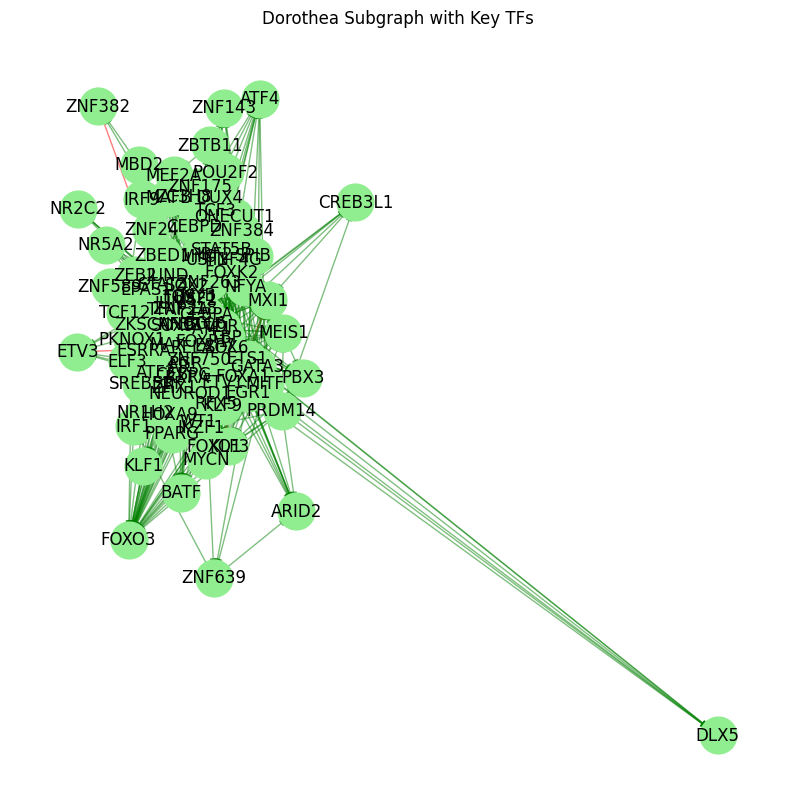

In [ ]:
# plot the modified graph
plot_dorothea_graph(G_reduced_copy_2)

In [ ]:
# print amount of nodes without outgoing edges in the reduced graph
num_nodes_without_outgoing_edges = sum(1 for n in G_reduced.nodes() if G_reduced.out_degree(n) == 0)
print(f"Number of nodes without outgoing edges in reduced graph: {num_nodes_without_outgoing_edges}")


Number of nodes without outgoing edges in reduced graph: 0


In [ ]:
# store the reduced graph as a topo file
create_topo_file_from_graph("dorothea_100", G_reduced_copy_2, Path("../topos/"))

In [ ]:
reduced_75 = reduce_graph_to_n_nodes(G_reduced_copy_2, 75)
# store the reduced graph with 75 nodes as a topo file
create_topo_file_from_graph("dorothea_75", reduced_75, Path("../topos/"))

In [ ]:
reduced_50 = reduce_graph_to_n_nodes(reduced_75, 50)
# store the reduced graph with 50 nodes as a topo file
create_topo_file_from_graph("dorothea_50", reduced_50, Path("../topos/"))

In [ ]:
# starting at node TP53, create a subgraph with 150 nodes that is biologically relevant
def create_biologically_relevant_subgraph(G, start_node, num_nodes):
    """
    Create a subgraph starting from a given node and expanding to include a specified number of nodes.
    :param G: nx Graph
    :param start_node: Node to start the subgraph from
    :param num_nodes: Number of nodes to include in the subgraph
    :return: Subgraph with the specified number of nodes
    """
    if not G.has_node(start_node):
        raise ValueError(f"Start node {start_node} is not in the graph.")
    
    # Perform a breadth-first search to find the subgraph
    sub_nodes = set()
    queue = [start_node]
    
    while queue and len(sub_nodes) < num_nodes:
        current_node = queue.pop(0)
        if current_node not in sub_nodes:
            sub_nodes.add(current_node)
            neighbors = list(G.neighbors(current_node))
            for neighbor in neighbors:
                if neighbor not in sub_nodes:
                    queue.append(neighbor)
    
    return G.subgraph(sub_nodes).copy()

In [ ]:
MTOR_nodes = ["IGF1R","INSR","IRS1","PIK3CA","PIK3CB","PIK3CD","PIK3R1","PIK3R2","PIK3R3","RAF1","BRAF","MAPK1","MAPK3","HRAS","KRAS","NRAS","MAP2K1",
              "MAP2K2","PTEN","PDPK1","AKT3","AKT1","AKT2","TSC1","TSC2","RHEB","EIF4EBP1","LPIN1","LPIN2","RPS6KB1","RPS6KB2","RHOA","PRKCA","PRKCB",
              "PRKCG","SGK1","RRAGB","RRAGA","RRAGD","RRAGC","RPS6KA6","RPS6KA1","RPS6KA2","RPS6KA3","PRKAA1","PRKAA2","GRB2","DDIT4","EIF4E","EIF4E2",
              "ULK1","ULK2","RPS6","TNF","IKBKB","TNFRSF1A","SLC7A5","SLC3A2","SOS1","SOS2","NPRL2","NPRL3","DEPDC5","SKP2","MIOS","SEC13","WDR59",
              "SEH1L","ATP6V1D","ATP6V1H","ATP6V1A","ATP6V1B1","ATP6V1B2","ATP6V1C1","ATP6V1E1","ATP6V1F","ATP6V1G1","LAMTOR5","LAMTOR2","LAMTOR3",
              "CHUK","IGF1","INS","GRB10","FLCN","EIF4B","MTOR","DEPTOR","MLST8","TTI1","TELO2","PRR5","PRR5L","MAPKAP1","GSK3B","WNT16","WNT4","WNT1",
              "WNT2","WNT3","WNT5A","WNT6","WNT7A","WNT8B","WNT10B","WNT11","WNT2B","WNT5B","FZD10",
              "FZD2","FZD5","FZD3","FZD1","FZD4","FZD6","FZD7","FZD8","FZD9","LRP6","LRP5","DVL1","DVL2","DVL3","CLIP1","STK11","STRADA","CAB39","CAB39L"]
MAPK_nodes = ["RASGRF1","DUSP10","DUSP1","DUSP2","DUSP4","DUSP5","DUSP6","DUSP7","DUSP8","DUSP9","DUSP3","PTPN7","PTPRR","PPM1B","FASLG","MAP4K4",
              "PLA2G4A","PLA2G4C","STMN1","MAPT","NFKB1","NFKB2","RELA","RELB","CHUK","IKBKB","IKBKG","MAPK1","MAPK3","LAMTOR3","MAP2K2","MAP2K1",
              "RAF1","BRAF","RASA1","NF1","PRKCA","PRKCB","PRKCG","RAP1A","RAP1B","PRKACA","PRKACB","PRKACG","RAPGEF2","RASA2","RRAS2","MRAS","HRAS",
              "KRAS","NRAS","RRAS","RASGRP1","RASGRP2","RASGRP3","SOS1","SOS2","GNA12","GNG12","GRB2","CSF1R","EGFR","EPHA2","ERBB2","ERBB3","ERBB4",
              "FGFR1","FGFR3","FGFR2","FGFR4","FLT1","FLT3","FLT4","IGF1R","INSR","KDR","KIT","MET","NGFR","NTRK1","NTRK2","PDGFRA","PDGFRB","RET",
              "TEK","CACNG3","CACNG2","CACNG5","CACNG4","CACNA2D3","CACNA1A","CACNA1B","CACNA1C","CACNA1D","CACNA1E","CACNA1F","CACNA1S","CACNA2D1",
              "CACNB1","CACNB2","CACNB3","CACNB4","CACNG1","CACNA1I","CACNA1H","CACNA1G","CACNA2D2","NR4A1","MAPK7","MAP2K5","NLK","CDC25B","RPS6KA4",
              "RPS6KA5","MAPKAPK3","MAPKAPK2","ATF4","MEF2C","MAX","DDIT3","ELK4","TP53","ELK1","ATF2","MAPK14","MAPK11","MAPK13","PPP5C","MAP2K6",
              "MAP2K3","PPM1A","AKT3","AKT1","AKT2","TAOK3","TAOK1","TAOK2","MAP3K4","HSPB1","MAP3K7","MAP3K5","MAP3K6","MAP3K20","MAP3K12","MAP3K13",
              "MAP3K9","MAP3K10","MAP4K2","STK3","STK4","ECSIT","TAB2","TAB1","GADD45G","GADD45A","GADD45B","TRAF6","DAXX","TRAF2","CASP3","CD14",
              "TGFBR1","TGFBR2","FAS","IL1R1","IL1RAP","TNFRSF1A","TGFB1","TGFB2","TGFB3","IL1A","IL1B","TNF","MAPKAPK5","RAC1","RAC2","RAC3","CDC42",
              "PAK1","PAK2","MAP3K2","MAP3K3","MAPK8IP2","MAPK8IP1","MAP3K11","MAP2K7","MAPK8","MAPK9","MAPK10","MAP2K4","CRK","CRKL","ARRB1","ARRB2",
              "MECOM","HSPA1A","HSPA1L","HSPA6","HSPA8","JUND","FOS","JUN","NFATC3","NFATC1","PPP3CA","PPP3CB","PPP3CC","PPP3R1","MAPK8IP3","FLNA",
              "MAP3K1","MAP3K8","MAP4K1","MAP4K3","SRF","MYC","RPS6KA6","RPS6KA1","RPS6KA2","RPS6KA3","MKNK2","MKNK1","CSF1","EFNA1","EFNA2","EFNA3",
              "EFNA4","EFNA5","EGF","EREG","FGF1","FGF2","FGF3","FGF4","FGF5","FGF6","FGF7","FGF8","FGF9","VEGFD","FLT3LG","FGF20","FGF21","GDNF",
              "FGF22","ANGPT1","ANGPT2","HGF","IGF1","INS","AREG","KITLG","NGF","NRTN","NTF3","ANGPT4","PDGFA","PDGFB","PGF","PDGFC","PSPN","BDNF",
              "TGFA","VEGFA","VEGFB","VEGFC","PDGFD","FGF23","FGF18","FGF17","ARTN","TRADD","MYD88","IRAK1","IRAK4","ARAF",]
TP53_nodes = ["SIAH1","IGFBP3","GADD45G","GADD45A","GADD45B","MDM4","CHEK1","ATR","CHEK2","ATM","RPRM","SFN","CDK2","CCNE1","CCNE2","TSC2","PPM1D",
              "TP73","CCNG1","CCNG2","RRM2","DDB2","STEAP3","PTEN","SERPINB5","CD82","THBS1","IGF1","SERPINE1","ADGRB1","CDKN2A","CDKN1A","ZMAT3",
              "BID","EI24","TP53I3","FAS","GTSE1","BAX","PIDD1","TNFRSF10B","CASP8","CDK1","APAF1","CYCS","CASP9","MDM2","TP53","RCHY1","CDK4","CDK6",
              "CCND1","CCND2","CCND3","PERP","SESN1","CCNB1","CCNB2","CASP3","TP53AIP1","BBC3","PMAIP1","SIVA1","BCL2L1","BCL2","PPP1R13L",]

Subgraph with MAPK nodes: 224 nodes, 632 edges
Number of weakly connected components in MAPK subgraph: 1


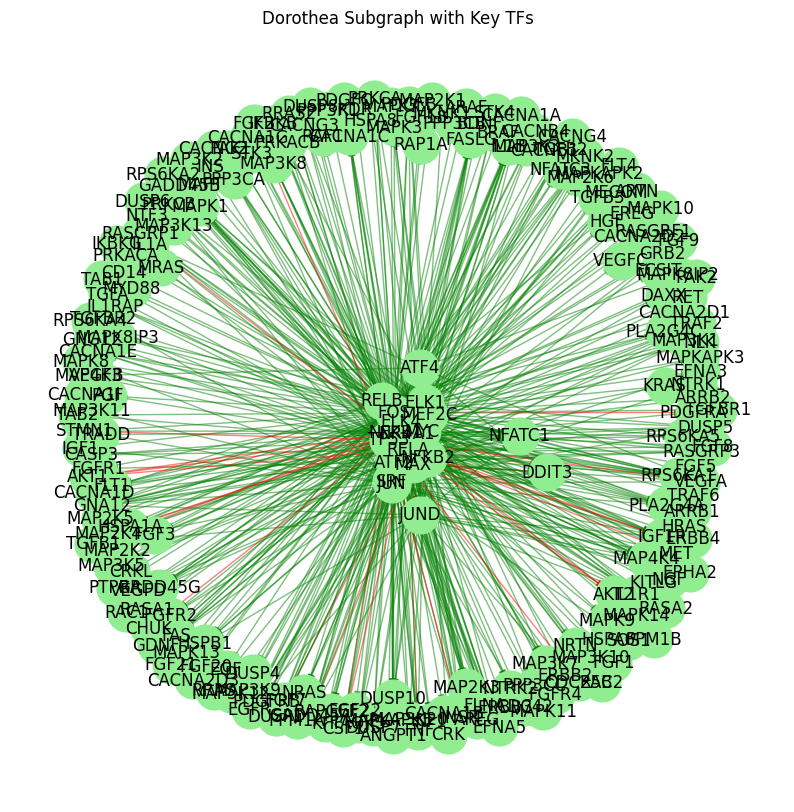

In [ ]:
# Create a subgraph with the MTOR nodes
G_sub = G_filtered.subgraph(MAPK_nodes).copy()  
# drop isolated nodes
G_sub.remove_nodes_from(list(nx.isolates(G_sub)))
print(f"Subgraph with MAPK nodes: {G_sub.number_of_nodes()} nodes, {G_sub.number_of_edges()} edges")
# print number and size of weakly connected components
num_components = nx.number_weakly_connected_components(G_sub)
print(f"Number of weakly connected components in MAPK subgraph: {num_components}")  

# plot the subgraph
plot_dorothea_graph(G_sub)

In [ ]:


# Step 1: pick key TFs
seed_tfs = ['MTOR']  # good hubs
# seed_tfs = ['TP53']  # good hubs
N_NODES = 150  # maximum number of nodes in the subgraph

# Step 2: find their targets
nodes = set(seed_tfs)
for tf in seed_tfs:
    nodes.update(G.successors(tf))  # first-degree targets

# Optional: add second layer to enrich cycles
for node in list(nodes):
    nodes.update(G.successors(node))

# Step 3: Create the subgraph
G_sub = G.subgraph(nodes).copy()

# Optionally reduce to top 50 nodes by degree
if len(G_sub) > N_NODES:
    top_nodes = sorted(G_sub.degree, key=lambda x: -x[1])[:N_NODES]
    G_sub = G_sub.subgraph([n for n, _ in top_nodes]).copy()

# Print info
print(f"Subgraph: {G_sub.number_of_nodes()} nodes, {G_sub.number_of_edges()} edges")



Subgraph: 1 nodes, 0 edges


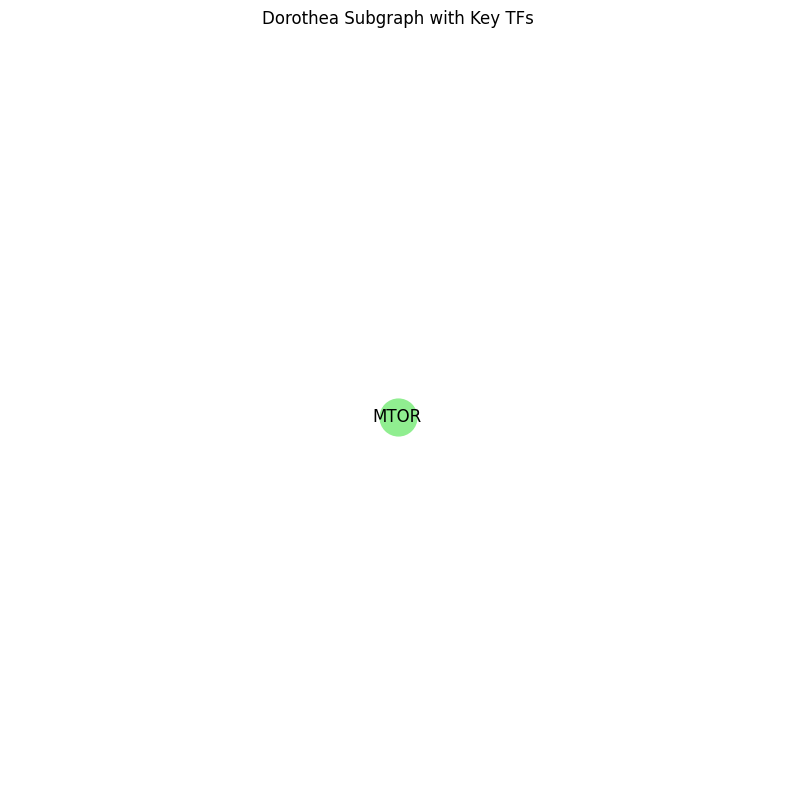

In [ ]:
plot_dorothea_graph(G_sub)

In [ ]:
# Create topo file
create_topo_file_from_graph("dorothea_tp53_myc", G_filtered, "../../data/topos")

FileNotFoundError: [Errno 2] No such file or directory: '../../data/topos/dorothea_tp53_myc.topo'